In [1]:
import re
import string
import json
from pprint import pprint
from functools import partial
from operator import itemgetter, attrgetter
from os.path import normpath
from typing import Callable

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.parsing.preprocessing import STOPWORDS
from sacremoses import MosesTokenizer, MosesTruecaser
from sklearn.base import clone
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    SelectPercentile,
    GenericUnivariateSelect,
)
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import (
    LogisticRegression,
    LogisticRegressionCV,
    PassiveAggressiveClassifier,
    RidgeClassifier,
    RidgeClassifierCV,
    SGDClassifier,
)
from sklearn.naive_bayes import (
    BernoulliNB,
    CategoricalNB,
    ComplementNB,
    GaussianNB,
    MultinomialNB,
)
from sklearn.svm import LinearSVC, NuSVC, OneClassSVM, SVC
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedStratifiedKFold,
    StratifiedKFold,
    train_test_split,
)
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import (
    Binarizer,
    FunctionTransformer,
    MaxAbsScaler,
    MinMaxScaler,
    minmax_scale,
    Normalizer,
    normalize,
    PowerTransformer,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    PolynomialFeatures,
)
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

import dask
import dask.dataframe as dd

# Set Seaborn theme and default palette
sns.set_theme(font_scale=1.25, style="darkgrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
# Import my modules
from tools import cleaning, plotting, language as lang, outliers, utils
from tools.sklearn.vectorizers import FreqVectorizer, VaderVectorizer
from tools.sklearn.classification import diagnostics as diag
from tools.sklearn import selection

# Run time-consuming grid searches
RUN_SWEEPS = False

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

# dask.config.set(scheduler="threading")

<IPython.core.display.Javascript object>

In [3]:
df = pd.read_parquet(
    "data/amazon_clean",
    engine="pyarrow",
    columns=[
        "category",
        "main_cat",
        "description",
        "title",
        "brand",
        "price",
        "asin",
    ],
)
display(df.head())
df.shape

,category,main_cat,description,title,brand,price,asin
137,"[luggage & travel gear, travel duffels]",all beauty,Carry your light travel necessities comfortabl...,Clava One Pocket 20&quot; Duffel (Vachetta Tan),None,185.16,B000078OSM
352,"[women, watches, wrist watches]",all beauty,The lady's watch has a .75 inch diameter face ...,Timex Indiglo Watch Ladies Gold with Expansion...,magnifying aids,99.95,B00012KBNS
380,"[novelty & more, clothing, novelty, women, acc...",all beauty,Rain Wear 855 Rain Visor Black.,"Andre Rain Wear 855 Rain Visor, Black, One Siz...",None,3.99,B000172RMG
381,"[men, watches, wrist watches]",all beauty,"Rich design, this stylish, polish finish, two-...",Mens Royal Tel Time Bi Color Talking Watch wit...,None,49.95,B000186WR6
836,"[novelty & more, clothing, novelty, women, soc...",all beauty,<strong>Maggie's Organic Cotton Tie Dye Crew S...,Maggie's Organics - Organic Cotton Tie Dye Cre...,None,23.40,B0002HS1MU


(4177422, 7)

<IPython.core.display.Javascript object>

In [4]:
df.isna().sum()

category             0
main_cat             0
description          0
title                0
brand          2708775
price            78365
asin                 0
dtype: int64

<IPython.core.display.Javascript object>

In [5]:
df = df.dropna()
df.isna().sum()

category       0
main_cat       0
description    0
title          0
brand          0
price          0
asin           0
dtype: int64

<IPython.core.display.Javascript object>

In [6]:
df["text"] = df["title"] + " " + df["description"]
df.head()

,category,main_cat,description,title,brand,price,asin,text
352,"[women, watches, wrist watches]",all beauty,The lady's watch has a .75 inch diameter face ...,Timex Indiglo Watch Ladies Gold with Expansion...,magnifying aids,99.95,B00012KBNS,Timex Indiglo Watch Ladies Gold with Expansion...
1116,"[women, shoes]",all beauty,CLICK-04-1 Platform Kitty Cat Felt T-Strap Sho...,Demonia Women's CLICK-04-1 Platform Kitty Cat ...,demonia,5.91,B0002YE8VQ,Demonia Women's CLICK-04-1 Platform Kitty Cat ...
5064,[men],all beauty,Do you want a rugged neoprene zipper case to p...,Chums Shade Shelter Sunglass Case in Black,chums,14.84,B000FH2PEC,Chums Shade Shelter Sunglass Case in Black Do ...
7837,"[costumes & accessories, men, accessories]",all beauty,Tube of Fake Blood,Halloween Tube Of Fake Blood,fun world,6.98,B000JFR9IM,Halloween Tube Of Fake Blood Tube of Fake Blood
9051,"[women, watches, wrist watches]",all beauty,"With one button, this new watch now offers the...",Talking Watch Unisex English,magnifying aids,79.95,B000M529Q6,"Talking Watch Unisex English With one button, ..."


<IPython.core.display.Javascript object>

In [7]:
df["weight"] = compute_sample_weight("balanced", y=df.main_cat)
df.head()

,category,main_cat,description,title,brand,price,asin,text,weight
352,"[women, watches, wrist watches]",all beauty,The lady's watch has a .75 inch diameter face ...,Timex Indiglo Watch Ladies Gold with Expansion...,magnifying aids,99.95,B00012KBNS,Timex Indiglo Watch Ladies Gold with Expansion...,19.143145
1116,"[women, shoes]",all beauty,CLICK-04-1 Platform Kitty Cat Felt T-Strap Sho...,Demonia Women's CLICK-04-1 Platform Kitty Cat ...,demonia,5.91,B0002YE8VQ,Demonia Women's CLICK-04-1 Platform Kitty Cat ...,19.143145
5064,[men],all beauty,Do you want a rugged neoprene zipper case to p...,Chums Shade Shelter Sunglass Case in Black,chums,14.84,B000FH2PEC,Chums Shade Shelter Sunglass Case in Black Do ...,19.143145
7837,"[costumes & accessories, men, accessories]",all beauty,Tube of Fake Blood,Halloween Tube Of Fake Blood,fun world,6.98,B000JFR9IM,Halloween Tube Of Fake Blood Tube of Fake Blood,19.143145
9051,"[women, watches, wrist watches]",all beauty,"With one button, this new watch now offers the...",Talking Watch Unisex English,magnifying aids,79.95,B000M529Q6,"Talking Watch Unisex English With one button, ...",19.143145


<IPython.core.display.Javascript object>

In [8]:
df = df.sample(500_000, weights="weight", random_state=829)
df.head()

,category,main_cat,description,title,brand,price,asin,text,weight
2104458,"[electronics, accessories & supplies, audio & ...",all electronics,"Mitsubishi WD-57831, WD-65831, WD-73732, WD-73831",Comptible Mitsubishi Replacement TV Lamp for W...,fi lamps,2.00,B007RQ3LJ2,Comptible Mitsubishi Replacement TV Lamp for W...,1.584447
1881344,"[cds & vinyl, holiday & wedding]",digital music,Wedding Music ~ Wedding Album: Our Favortie Lov,Wedding Album: Our Favortie Love Songs,various artists,6.44,B000021YEP,Wedding Album: Our Favortie Love Songs Wedding...,3.432645
620237,"[home & kitchen, furniture, living room furnit...",amazon home,You can never have too much storage space. Giv...,Sauder Palladia Technology Pier Free Standing ...,sauder,21.29,B005EGLHYS,Sauder Palladia Technology Pier Free Standing ...,0.174315
2551086,"[office products, office & school supplies, pr...",office products,"This 14"" x 14"" canvas cork bulletin board adds...",Board Dudes 14 x 14 Inches Canvas Style Cork B...,the board dudes,15.14,B0055QJ0Y6,Board Dudes 14 x 14 Inches Canvas Style Cork B...,0.799806
4177656,"[software, education & reference, languages]",software,Instant Immersion is fun and easy to use! It i...,Instant Immersion Level 1 - Hawaiian [Download],topics entertainment,29.99,B005IHV2P2,Instant Immersion Level 1 - Hawaiian [Download...,51.635824


<IPython.core.display.Javascript object>

# Modeling

In [9]:
X = df.loc[:, ["text", "price", "brand"]]
y = df.loc[:, "main_cat"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=49, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((375000, 3), (125000, 3), (375000,), (125000,))

<IPython.core.display.Javascript object>

In [10]:
from sklearn.preprocessing import OneHotEncoder

col_xform = ColumnTransformer(
    [
        ("txt", FreqVectorizer(), "text"),
        ("prc", "drop", ["price"]),
        ("brd", OneHotEncoder(handle_unknown="ignore"), ["brand"]),
    ],
)
col_xform

ColumnTransformer(transformers=[('txt', FreqVectorizer(), 'text'),
                                ('prc', 'drop', ['price']),
                                ('brd', OneHotEncoder(handle_unknown='ignore'),
                                 ['brand'])])

<IPython.core.display.Javascript object>

In [11]:
pipe = Pipeline(
    [
        ("col", col_xform),
        ("cls", ComplementNB()),
    ]
)
pipe

Pipeline(steps=[('col',
                 ColumnTransformer(transformers=[('txt', FreqVectorizer(),
                                                  'text'),
                                                 ('prc', 'drop', ['price']),
                                                 ('brd',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['brand'])])),
                ('cls', ComplementNB())])

<IPython.core.display.Javascript object>

In [12]:
col_xform.fit_transform(X_train, y_train)

<375000x519069 sparse matrix of type '<class 'numpy.float64'>'
	with 23288723 stored elements in Compressed Sparse Row format>

<IPython.core.display.Javascript object>

In [13]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('col',
                 ColumnTransformer(transformers=[('txt', FreqVectorizer(),
                                                  'text'),
                                                 ('prc', 'drop', ['price']),
                                                 ('brd',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['brand'])])),
                ('cls', ComplementNB())])

<IPython.core.display.Javascript object>

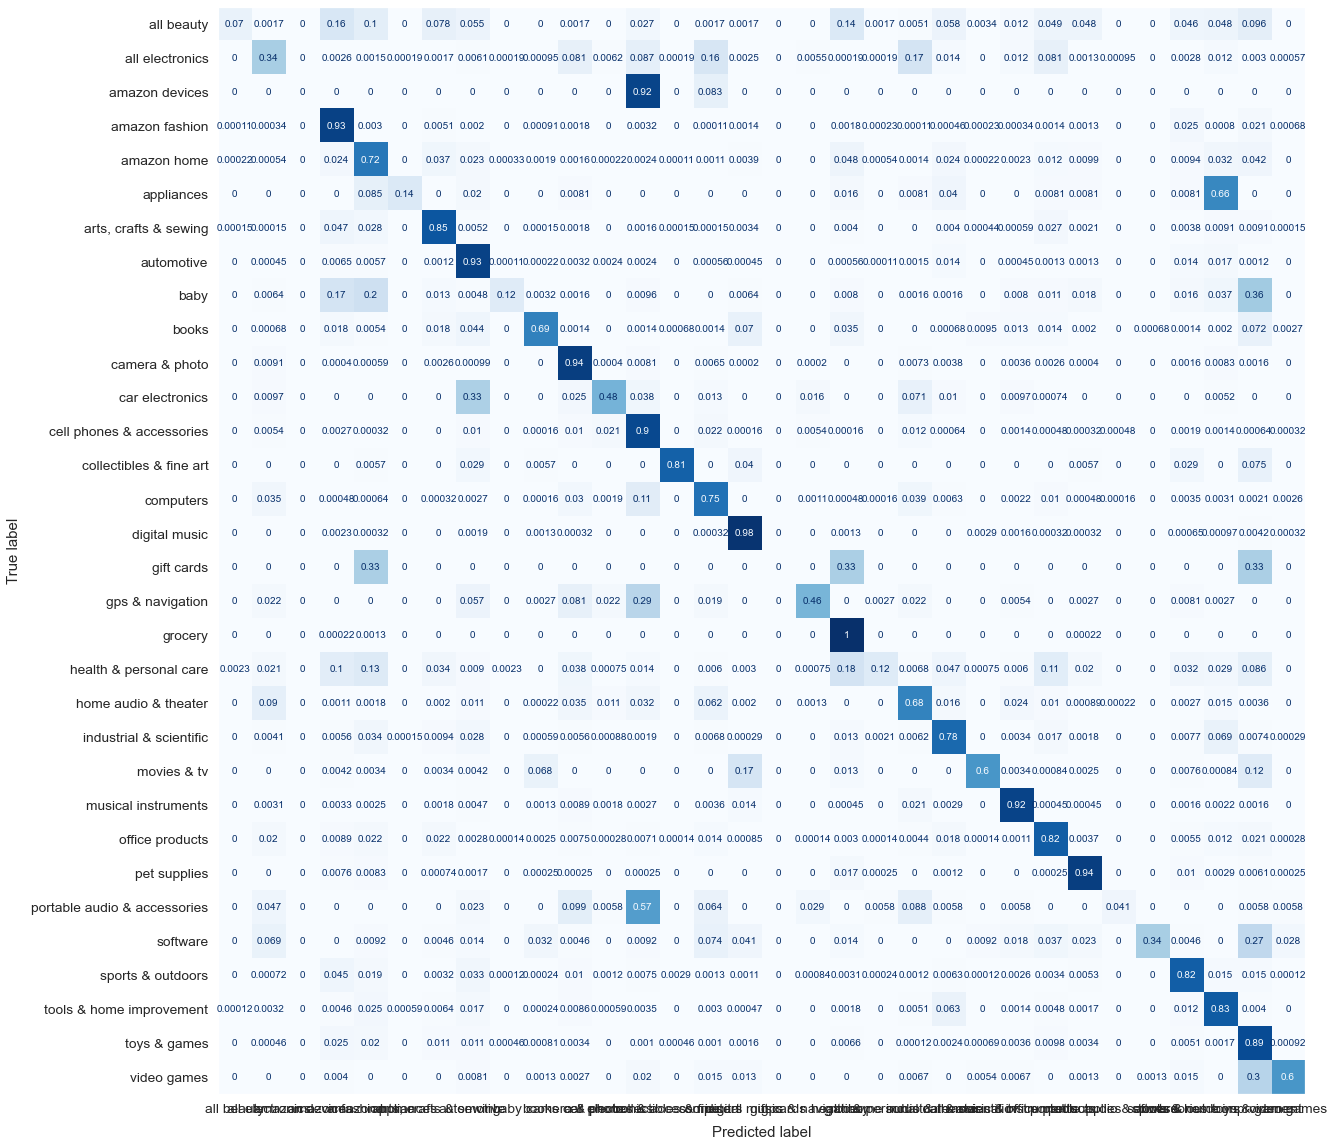

<IPython.core.display.Javascript object>

In [14]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(
    pipe, X=X_test, y_true=y_test, normalize="true", cmap="Blues", colorbar=False, ax=ax
)
ax.grid(False)

In [15]:
diag.classification_report(y_test, pipe.predict(X_test), heatmap=False).T

C:\Users\ndgig\Anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ndgig\Anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ndgig\Anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
all beauty,0.836735,0.069966,0.129134,0.004688
all electronics,0.640469,0.340582,0.444691,0.042304
amazon devices,0.000000,0.000000,0.000000,0.000096
amazon fashion,0.820137,0.929295,0.871310,0.070264
amazon home,0.798915,0.721817,0.758412,0.073448
appliances,0.829268,0.137652,0.236111,0.001976
"arts, crafts & sewing",0.856529,0.852737,0.854629,0.054216
automotive,0.822739,0.925686,0.871182,0.071480
baby,0.839080,0.117175,0.205634,0.004984
books,0.854008,0.685637,0.760616,0.011808


<IPython.core.display.Javascript object>